In [5]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal as d10

#Counters, flags
N = 32 #number of atoms for simulation
ovlp = 0 #atomic overlap flag
c, naccept, nt = 0, 0, 0 #counters
nadjst = 1000
max_trials = 1000000
max_states = int(0.6 * max_trials) #for initializing storing arrays

#Variables
sig = 0.34 #(in nm) max range(distance) of LJ
sigsq = sig**2.
rcut = sig #(in nm) LJ interactions to be considered only inside rcut
rcutsq = sigsq
ratom = 0.071 #(in nm) radius of atom
ratomsq = ratom**2.
drmax = ratom #(in nm) max distance an atom can move
bl = 8. * ratom #(in nm) box-length

#Constants
epslon = d10(1.65684 * 1e-23) #...*from book, for Argon
beta = d10(9.053378720938 * 1e20) #...*from book, for Argon, and temp 80K (liquid argon)

#Arrays for storing coordinates of centres of atoms and potential
rx, ry, rz, r_x, r_y, r_z = [], [], [], [], [], [] #atomic coordinates
#----supply initial positions----
a = np.linspace(0, bl-4*ratom, 2)
b = np.linspace(2*ratom, bl-2*ratom, 2)
z = 0.
for k in range(4):
    if (k % 2 == 0):
        for j in range(2):
            for i in range(2):
                rx.append(a[i])
                ry.append(a[j])
        for j in range(2):
            for i in range(2):
                rx.append(b[i])
                ry.append(b[j])
    else:
        for j in range(2):
            for i in range(2):
                rx.append(b[i])
                ry.append(a[j])
        for j in range(2):
            for i in range(2):
                rx.append(a[i])
                ry.append(b[j]) 
    for i in range(8):
        rz.append(z)
    z = z + 2*ratom
#--------------------------------
#store simulated states as revl[accepted_state][coordinates]
rxevl, ryevl, rzevl = np.zeros((max_states, N)), np.zeros((max_states, N)), np.zeros((max_states, N)) #evolution of atomic coordinates
rxevl[0], ryevl[0], rzevl[0] = rx, ry, rz
Varr = []
drmaxarr = []

In [6]:
#Function definitions

def LJ(r_x, r_y, r_z): #calculates Lennard-Jones(LJ) interaction potential 
    V = d10(0.0)
    for i in range(N-1):
        rxi = r_x[i]
        ryi = r_y[i]
        rzi = r_z[i]
        for j in range(i+1, N):
            rxij = rxi - r_x[j]
            ryij = ryi - r_y[j]
            rzij = rzi - r_z[j]
            rijsq = rxij**2. + ryij**2. + rzij**2.
            if (rijsq > rcutsq): continue
            sr2 = d10(sigsq)/d10(rijsq) #decimal
            sr6 = sr2*sr2*sr2
            sr12 = sr6*sr6
            V = V + sr12 - sr6
    V = d10(4) * epslon * V
    return V

def V_k(k, r_x, r_y, r_z, r_xk, r_yk, r_zk): #calculates LJ potential for k-th atom.
    Vk = d10(0.0) 
    for i in range(N):
        if (i == k): continue
        rxij = r_x[i] - r_xk
        ryij = r_y[i] - r_yk
        rzij = r_z[i] - r_zk
        rijsq = rxij**2. + ryij**2. + rzij**2.
        if (rijsq > rcutsq): continue
        sr2 = d10(sigsq)/d10(rijsq) #decimal
        sr6 = sr2*sr2*sr2
        sr12 = sr6*sr6
        Vk = Vk + sr12 - sr6
    Vk = d10(4) * epslon * Vk
    return Vk

def ovlp_check(k_, rxkn_, rykn_, rzkn_, ovlp): #checks if new (x,y,z) of k-th atom causes interatomic overlap, sets flag ovlp if there is overlap
    for i in range(N):
        if (i == k_): continue
        rsq = (rx[i] - rxkn_)**2. + (ry[i] - rykn_)**2. + (rz[i] - rzkn_)**2.
        if (rsq < 4. * ratomsq):
            ovlp = 1 #set flag if new state causes atomic overlap
            break
    return ovlp        

In [7]:
#main body

V = LJ(rx, ry, rz)
Varr.append(V)
np.random.seed(0)

for ntrial in range(max_trials):
    kk = np.random.randint(0, N) #select random k-th atom for changing state
    random2 = 2 * np.random.rand(3) #select 3 random increments for (x,y,z) of k's atomic coordinates.
    rxk, ryk, rzk = rx[kk], ry[kk], rz[kk] #save current coordinates of k.
    rxkn = rx[kk] + (random2[0] - 1.) * drmax
    rykn = ry[kk] + (random2[1] - 1.) * drmax
    rzkn = rz[kk] + (random2[2] - 1.) * drmax
    #----check if new state satisfies boundary conditions and doesn't cause atomic overlap----
    if (rxkn<0): rxkn = bl + rxkn   #If atom goes beyond one boundary,
    if (rykn<0): rykn = bl + rykn   #make it return from opposite boundary.
    if (rzkn<0): rzkn = bl + rzkn   #This makes the system infinite.
    if (rxkn>bl): rxkn = r.;xkn - bl
    if (rykn>bl): rykn = rykn - bl
    if (rzkn>bl): rzkn = rzkn - bl
    ovlp = ovlp_check(kk, rxkn, rykn, rzkn, ovlp) #check if interatomic overlap due to new (x,y,z) of k-th atom
    if (ovlp == 1): #check status of flag
        ovlp = 0 #reset flag
        continue #regenerate new state
    #-----------------------------------------------------------------------------------------
    c += 1 #Number of values that do not cause atomic overlap
    V_old = V_k(kk, rx, ry, rz, rx[kk], ry[kk], rz[kk]) #LJ potential for k-th atom of old state
    V_new = V_k(kk, rx, ry, rz, rxkn, rykn, rzkn) #LJ potential for k-th atom of new state
    dV = V_new - V_old
    dVB = beta * dV
    if (dVB < 75): #threshold
        #--------MC Metropolis--------
        if (dVB < 0):
            V = V + dV
            rx[kk], ry[kk], rz[kk] = rxkn, rykn, rzkn #accept the new state and store it as current state
            naccept += 1    #counts number of accepted values, starts recounting if drmax is changed
            nt += 1         #counts total accepted values, needed when using nadjst to adjust drmax every nadjst trials
            Varr.append(V)
            rxevl[nt], ryevl[nt], rzevl[nt] = rx, ry, rz
        elif (np.exp(-dVB) > np.random.rand()):
            V = V + dV
            rx[kk], ry[kk], rz[kk] = rxkn, rykn, rzkn
            naccept += 1
            nt += 1
            Varr.append(V)
            rxevl[nt], ryevl[nt], rzevl[nt] = rx, ry, rz
        #-----------------------------
    '''if (ntrial % nadjst == 0): #adjust drmax every nadjst
        ratio = float(naccept)/float(nadjst)
        if (ratio > 0.5): drmax = drmax * 1.05
        else: drmax = drmax * 0.95
        drmaxarr.append(drmax)
        naccept = 0'''

print 'Number of values that cause no atomic overlap = ' + str(c)
print 'Number of accepted values = ' + str(nt)
acr = float(float(nt)/float(max_trials))
print 'Acceptance Ratio = ' + str(acr)
print 'drmax = ' + str(drmax)
print 'Done!'

Number of values that cause no atomic overlap = 51650
Number of accepted values = 877
Acceptance Ratio = 0.00877
drmax = 0.071
Done!


Enter the simulated state to plot (initial state is 0, 1st simulated state is 1,... maximum is 877): 877


/home/pallav/.local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


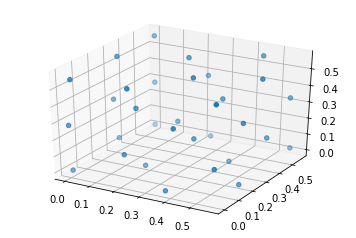

In [8]:
#Plot positions of atoms in simulated states
state = int(input('Enter the simulated state to plot (initial state is 0, 1st simulated state is 1,... maximum is %d): ' % (nt)))
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
ax.scatter3D(rxevl[state], ryevl[state], rzevl[state])
fig.show()

In [ ]:
#Plot positions of atoms in simulated states
state = int(input('Enter the simulated state to plot (initial state is 0, 1st simulated state is 1,... maximum is %d): ' % (nt)))
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
ax.scatter3D(rxevl[state], ryevl[state], rzevl[state])
fig.show()

3.820362061457651945331667957E-18 1.581755576182056527114373636E-19


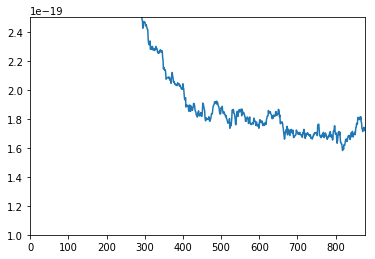

In [9]:
#Plot LJ Potential variation throughout the simulation
print max(Varr), np.min(Varr)
plt.plot(Varr)
plt.xlim(0, nt) #skip initial states as they have high correlations and are dependent on input coordinates
plt.ylim(1.0*1e-19, 2.5*1e-19)
plt.show()

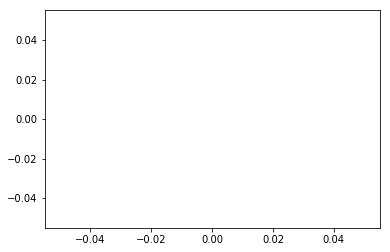

In [10]:
#Plot drmax variation when using nadjst
plt.plot(drmaxarr)
plt.show()

In [72]:
#Save array files
adjust = int(input('Was nadjst used for adjusting drmax every nadjst trials? (Input: 1 if Yes, 0 if No): '))
if (adjust == 1): change = '_adjust'
else: change = ''
np.savez('%s_atoms_in_a_box_%.2fnm%s.npz' % (N, bl, change),
         adjust = adjust,
         rxevl = rxevl[0:nt+1],
         ryevl = ryevl[0:nt+1],
         rzevl = rzevl[0:nt+1],
         Varr = Varr,
         acr = acr,
         drmaxarr = drmaxarr
         )
print 'Okay! Saved!'

Was nadjst used for adjusting drmax every nadjst trials? (Input: 1 if Yes, 0 if No): 1
Okay! Saved!


In [ ]:
#Load array files
array = np.load('64_atoms_in_a_box_0.99nm.npz')
rxevl = array['rxevl']
ryevl = array['ryevl']
rzevl = array['rzevl']
Varr = array['Varr']
acr = array['acr']
adjust = array['adjust']
drmaxarr = array['drmaxarr']

In [82]:
#Save final state to txt file for visualization through other software
st = 40000
file1 = open("%d_state.txt" % (st), "w")
for i in range(N):
    file1.write("%.8f\t%.8f\t%.8f\n" % (rxevl[st][i], ryevl[st][i], rzevl[st][i]))
file1.close()